<a href="https://colab.research.google.com/github/ClarisseAlvarenga/bootcamp_datascience_alura/blob/main/Projeto_M%C3%B3dulo3_BootCamp_Alura_Clarisse_Alvarenga.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Preparações Iniciais

In [115]:
#importação de bibliotecas
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import statsmodels as sm
import scipy.stats as st

In [19]:
#Buscando o arquivo
from zipfile import ZipFile
caminho = '/content/drive/MyDrive/bootcamp_alura/PeNSE_2015_AMOSTRA2.zip'
#abrindo o arquivo
zip = ZipFile(caminho)
#buscando apenas pelos nomes
zip.namelist()

['arquivos csv/',
 'arquivos csv/PENSE_AMOSTRA2_ALUNO.CSV',
 'arquivos csv/PENSE_AMOSTRA2_ALUNOESCOLA.CSV',
 'arquivos csv/PENSE_AMOSTRA2_ESCOLA.CSV',
 'arquivos sas/',
 'arquivos sas/pense_amostra2_aluno.sas7bdat',
 'arquivos sas/pense_amostra2_alunoescola.sas7bdat',
 'arquivos sas/pense_amostra2_escola.sas7bdat',
 'arquivos xlsx/',
 'arquivos xlsx/PENSE_AMOSTRA2_ALUNO.xlsx',
 'arquivos xlsx/PENSE_AMOSTRA2_ALUNOESCOLA.xlsx',
 'arquivos xlsx/PENSE_AMOSTRA2_ESCOLA.xlsx',
 'Dicionario_PENSE_Microdados_AMOSTRA2.xls']

In [20]:
#função para criar dicionário de acordo com as questões do dicionário
df_dict = pd.read_excel('https://github.com/IgorNascAlves/data-science-primeiros-passos/blob/master/Dicionario_PENSE_Microdados_AMOSTRA2.xls?raw=true')
def get_question_description(colum_name) -> dict:
    
    return_dict = dict()

    description_row = df_dict.query(f'VARIÁVEL == "{colum_name}"')['QUESTIONÁRIO DO ALUNO']
    return_dict['Pergunta'] = description_row.values[0]
   
    values = list()
    index = description_row.index[0] + 1
    value = df_dict.iloc[index]['VARIÁVEL']
    
    # foi necessario verificar se o primeiro caracter não é '-' que é utilizado na representação do -1
    while str(value)[0].isnumeric() or str(value)[0] == '-':
        values.append([value, df_dict.iloc[index]['QUESTIONÁRIO DO ALUNO']])
        index += 1
        value = df_dict.iloc[index]['VARIÁVEL']
    return_dict['Descrição'] = dict(values)
    
    return return_dict

In [21]:
#passando o arquivo que eu quero para uma análise descritiva
caminho_na_pasta_zipada = zip.namelist()[1]
#lendo o arquivo
dados = pd.read_csv(zip.open(caminho_na_pasta_zipada), sep=';', thousands = ".", decimal=",")

In [260]:
def highlight_max(s):
    '''
    highlight the maximum in a Series yellow.
    '''
    is_max = s == s.max()
    return ['background-color: yellow' if v else '' for v in is_max]

# **ANALISANDO O BULLYING PELA APARÊNCIA DO CORPO NOS DADOS DO PeNSE 2015**

o PeNSE é uma pesquisa nacional de saúde do escolar. Contém dados sócio Econômicos e também dados sobre os hábitos e rotinas de alimentação e exercício, etc. Traz insights não só sobre a saúde física do respondente, mas de sua saúde mental, e de fatores externos que podem exacerbar certas condições, e pode servir de direcionador para políticas públicas de ensino. Possui 181 colunas. Estes dados são de 2015.

Importante notar que estes dados contém apenas dados dos alunos que aceitaram participar da pesquisa, o que faz pensar que havia a opção de não responder à pesquisa. Temos dados de 16556 alunos que aceitaram responder o questionário. Trata-se de um questionário autoaplicável, o que pode gerar viés nas respostas.

O público da amostra é composto exclusivamente por estudantes, entre o 6º ano do Ensino Fundamental e o 3º ano do Ensino Médio, com público alvo entre 11 e 17 anos (apesar da possibilidade de possuir menos ou mais idade, tendo respondentes com 19 anos ou mais).   

Estas informações devem ser levadas em consideração ao tirarmos quaisquer conclusões relacionadas a estes dados.

## **RESUMO DA ANÁLISE**

Efetuamos uma análise predominantemente descritiva sobre o PeNSE 2015, focando nas questões relativas ao Bullying e suas implicações nas demais áreas envolvendo imagem corporal, gênero e idade.

## **ANÁLISE EXPLORATÓRIA** 

In [287]:
#visualizando os dados iniciais:
dados.head()

,REGEOGR,VB01001,VB01002,VB01003,VB01004,VB01005,VB01006,VB01007,VB01008A,VB01010A,VB01011,VB01012,VB01013,VB01014,VB01015A,VB01016,VB01017,VB01018,VB01019,VB01020A,VB01021,VB01022,VB01023,VB01024,VB01025,VB01026,VB02001,VB02002,VB02004A,VB02010,VB02011,VB02013,VB02017A,VB02018A,VB02019A,VB02020A,VB02021,VB02022,VB02023,VB02024,...,VB11005,VB11006,VB11007,VB12001,VB12002,VB12003,VB13001,VB13002A,VB13004A,VB13005,VB13006,VB13007,VB13008,VB13009,VB14001,VB14002,VB16001A01,VB16001A02,VB16001A03,VB16001A04,VB16001A05,VB16001A06,VB16001A07,VB16001A08,VB17001,VB17002,VB17003,VB17004,VB17005,VB17006,ESTRATO_EXP,ESTRATOGEOREG,PESO,V0006,V0007,V0008,V0041,aluno,escola,turma
0,1,2,1,13,7,7,1,2,7,3,2,-1,1,1,1,1,1,2,4,2,4,1,2,2,5,1,8,3,4,3,6,6,1,6,1,-1,2,4,3,1,...,2,1,2,1,1,4,2,-1,3,1,1,-1,1,1,2,2,1,2,2,2,2,2,2,2,371.0,1570.0,37.1,157.0,2,1,1223,1,299.735235,1,2,4,1,1,1,296
1,1,2,1,14,4,7,1,1,7,3,2,-1,1,1,1,1,1,2,2,2,4,1,2,2,5,3,8,2,1,8,8,6,1,1,5,-1,2,5,2,1,...,2,3,2,4,4,4,1,2,3,3,1,-1,1,1,2,2,2,2,2,1,2,2,2,2,502.0,1520.0,50.2,152.0,2,2,1223,1,355.170081,1,2,4,1,2,1,296
2,1,1,4,13,6,7,1,1,5,5,2,-1,2,1,1,1,1,2,3,1,4,1,2,2,5,3,2,3,1,8,2,8,1,1,5,5,1,8,5,1,...,2,1,2,1,2,3,1,2,1,2,5,99,1,-1,2,2,1,1,1,1,1,1,1,1,482.0,1614.0,48.2,161.4,2,2,1223,1,299.735235,1,2,4,1,3,1,296
3,1,1,1,14,6,7,1,1,7,4,2,-1,1,1,1,1,1,2,4,2,4,1,2,2,6,3,2,4,1,3,2,7,1,5,1,-1,2,5,3,1,...,2,1,2,2,2,4,1,10,3,1,2,-1,1,-1,2,2,1,2,2,2,1,2,2,2,694.0,1725.0,69.4,172.5,2,3,1223,1,355.170081,1,2,4,1,4,1,296
4,1,1,1,13,9,7,1,2,5,4,2,-1,2,1,1,1,1,2,5,1,4,1,2,2,6,5,6,3,5,2,6,2,1,5,1,5,1,3,2,3,...,2,1,4,2,2,4,1,3,2,2,2,13,1,-1,1,2,1,1,1,1,1,1,1,1,789.0,1675.0,78.9,167.5,2,4,1223,1,299.735235,1,2,4,1,5,1,296


In [23]:
#conferindo o tamanho da amostra
dados.shape

(16556, 181)

In [24]:
#conferindo nulos
dados.isna().sum().sum()

432

In [25]:
dados.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16556 entries, 0 to 16555
Columns: 181 entries, ANOPESQ to turma
dtypes: float64(10), int64(171)
memory usage: 22.9 MB


In [26]:
get_question_description(dados.columns[1])

{'Descrição': {76: 'Brasil'}, 'Pergunta': 'País'}

### **ANÁLISES PRELIMINARES**

Lendo o dicionário de dados, notei que há várias sub-áreas das perguntas, portanto vou dividir os dados em sub grupos de acordo com as perguntas do questionário

In [27]:
#vamos começar excluindo as colunas que possuem um único dado
colunas = []
#conferindo colunas com dados únicos
for column in dados.columns:
  if len(dados[column].unique()) <=1:
    colunas.append(column)
colunas

['ANOPESQ', 'PAIS', 'VB00004']

In [28]:
#excluindo colunas com dados únicos
dados.drop(colunas, axis=1, inplace=True)

In [29]:
def cria_subset_por_inicio_nome_coluna(dados: dados,query):
  return dados[[col for col in dados.columns if col.startswith(query)]]

Ao analisar os MicroDados da pesquisa, notei que estas estão divididas em seções, que dividi em subsets para facilitar a compreensão. 

**VB01 - Dados sócio-econômicos do aluno** tais como gênero, raça, idade, mês de aniversário, em que ano estuda, regime de estudo, se mora com os pais, a situação econômica da família (acesso à internet, computador, carro, empregado doméstico, grau de escolaridade da mãe)

**VB02 - Hábitos Alimentares** tais como consumo de café da manhã, oferecimento de merenda escolar, consumo de produtos industrializados, frituras, doces e frutas divididos em seções nos últimos 7 dias e nos últimos 30 dias.

**VB03 - Hábitos de Exercício** tais como prática de esportes, educação física, uso de meios de transporte alternativos (bicicleta) 

**VB04 - Fumo** com perguntas sobre uso de tabaco tanto pelo adolescente quanto pelos pais

**VB05 - Álcool** contendo perguntas relacionadas ao consumo de bebidas alcóolicas

**VB06 - Drogas Ilícitas** Contendo perguntas relacionadas ao uso de drogas pelo respondente e pelos amigos

**VB07 - Controle Parental e Bullying** questões tais como a presença dos pais e dos amigos na vida do estudante e situações de constrangimento e bullying

**VB08 - Hábitos Sexuais** incluindo questões sobre educação sexual. Foco no sexo consensual

**VB09 - Segurança** Sensação de segurança dentro e fora da escola, uso de cinto de segurança, uso de capacete, perguntas sobre agressão física e violência sexual

**VB10 - Hábitos de Higiene** lavar as mãos, higiene bucal

**VB11 - Imagem Corporal** nível de satisfação com a aparência física

**VB12 - Bem estar emocional** quantidade de amigos, e questões de saúde mental

**VB13 - Percepção sobre saúde** perguntas sobre como o aluno se sente de saúde, vacina HPV,e qual tipo de atendimento de saúde a família usa 

**VB14 - Saúde respiratória** duas perguntas, uma sobre chiado no peito, outra sobre asma.

**VB16 - Perguntas sobre o próprio questionário** se é chato, legal, interessante, informativo ou constrangedor

**VB17 - Dados biométricos** peso e altura do estudante

**V0 - Dados sobre a escola** 

In [30]:
sociais = cria_subset_por_inicio_nome_coluna(dados, 'VB01')
sociais.head(1)

,VB01001,VB01002,VB01003,VB01004,VB01005,VB01006,VB01007,VB01008A,VB01010A,VB01011,VB01012,VB01013,VB01014,VB01015A,VB01016,VB01017,VB01018,VB01019,VB01020A,VB01021,VB01022,VB01023,VB01024,VB01025,VB01026
0,2,1,13,7,7,1,2,7,3,2,-1,1,1,1,1,1,2,4,2,4,1,2,2,5,1


Nossa primeira análise vai focar nas perguntas relacionadas à seção VB07 do questionário, relacionadas aos dados sociais dos alunos (idade, gênero, região). Estas questões envolvem o acompanhamento parental e questões sobre bullying. Minha hipótese é que esta seção tem relação com as seções de segurança e bem estar emocional, e pode até interferir nas questões de auto-imagem. Nossos testes estatísticos vão explorar essas questões

### **OS EFEITOS DO BULLYING**

In [47]:
#visualizando quais questões sociais
questoes_ambiencia = df_dict.loc[df_dict['VARIÁVEL'].str.contains("VB01") == True]
questoes_ambiencia['QUESTIONÁRIO DO ALUNO'].to_list()

['Qual é o seu sexo?',
 'Qual é a sua cor ou raça?',
 'Qual é a sua idade?',
 'Qual é o mês do seu aniversário?',
 'Em que ano você nasceu?',
 'Em que ano/série você está?',
 'Em que turno você estuda?',
 'Você estuda em regime integral (tem atividades escolares por 7 horas ou mais horas diárias, durante todo o período escolar)?',
 'Você estuda em regime de internato (a escola possui alojamento onde os alunos permanecem e dormem diariamente, durante todo o período escolar)?',
 'Qual o grau de escolaridade mais elevado que você pretendo concluir?',
 'Quando terminar o ciclo/curso que você está frequentando atualmente, você pretende?',
 'Você mora com sua mãe?',
 'Você mora com seu pai?',
 'Contando com você, quantas pessoas moram na sua casa ou apartamento?',
 'Na sua casa tem telefone fixo (convencional)?',
 'Você tem celular?',
 'Na sua casa tem computador (de mesa, ou netbook, laptop, etc)?',
 'Você tem acesso à internet em sua casa?',
 'Alguém que mora na sua casa tem carro?',
 'Alg

In [48]:
#visualizando quais questões englobam a seção de ambiência
questoes_ambiencia = df_dict.loc[df_dict['VARIÁVEL'].str.contains("VB07") == True]
questoes_ambiencia['QUESTIONÁRIO DO ALUNO'].to_list()

['NOS ÚLTIMOS 30 DIAS, em quantos dias você faltou às aulas ou à escola sem permissão dos seus pais ou responsáveis?',
 'NOS ÚLTIMOS 30 DIAS, com que frequência seus pais ou responsáveis sabiam realmente o que você estava fazendo em seu tempo livre?',
 'NOS ÚLTIMOS 30 DIAS, com que frequência seus pais ou responsáveis verificaram se os seus deveres de casa (lição de casa) foram feitos?',
 'NOS ÚLTIMOS 30 DIAS, com que frequência seus pais ou responsáveis entenderam seus problemas e preocupações?',
 'NOS ÚLTIMOS 30 DIAS, com que frequência seus pais ou responsáveis mexeram em suas coisas sem a sua concordância?',
 'NOS ÚLTIMOS 30 DIAS, com que frequência os colegas de sua escola trataram você bem e/ou foram prestativos contigo?',
 'NOS ÚLTIMOS 30 DIAS, com que frequência algum dos seus colegas de escola te esculacharam, zoaram, mangaram, intimidaram ou caçoaram tanto que você ficou magoado, incomodado, aborrecido, ofendido ou humilhado?',
 'NOS ÚLTIMOS 30 DIAS, qual o motivo/causa de se

In [49]:
questoes_seguranca = df_dict.loc[df_dict['VARIÁVEL'].str.contains("VB09") == True]
questoes_seguranca['QUESTIONÁRIO DO ALUNO'].to_list()

['NOS ÚLTIMOS 30 DIAS, em quantos dias você deixou de ir à escola porque não se sentia seguro no caminho de casa para a escola ou da escola para casa?',
 'NOS ÚLTIMOS 30 DIAS, em quantos dias você não foi à escola porque não se sentia seguro na escola?',
 'NOS ÚLTIMOS 30 DIAS, com que frequência você usou cinto de segurança enquanto andava como passageiro(a) no BANCO DA FRENTE de carro/automóvel, van ou táxi?',
 'NOS ÚLTIMOS 30 DIAS, com que frequência você usou cinto de segurança enquanto andava como passageiro(a) no BANCO DE TRÁS de carro/automóvel, van ou táxi?',
 'NOS ÚLTIMOS 30 DIAS, com que frequência você usou capacete ao andar de motocicleta?',
 'NOS ÚLTIMOS 30 DIAS, quantas vezes você dirigiu um veículo motorizado de transporte (carro, motocicleta, voadeira, barco)?',
 'NOS ÚLTIMOS 30 DIAS, quantas vezes você andou em carro ou outro veículo motorizado dirigido por alguém que tinha consumido alguma bebida alcoólica?',
 'NOS ÚLTIMOS 30 DIAS, quantas vezes você foi agredido(a) fi

In [50]:
questoes_emocional = df_dict.loc[df_dict['VARIÁVEL'].str.contains("VB12") == True]
questoes_emocional['QUESTIONÁRIO DO ALUNO'].to_list()

['NOS ÚLTIMOS 12 MESES com que frequência tem se sentido sozinho(a)? ',
 'NOS ÚLTIMOS 12 MESES, com que frequência você não conseguiu dormir à noite porque algo o(a) preocupava muito? ',
 'Quantos amigos(as) próximos você tem?']

In [51]:
questoes_imagem = df_dict.loc[df_dict['VARIÁVEL'].str.contains("VB11") == True]
questoes_imagem['QUESTIONÁRIO DO ALUNO'].to_list()

['Você considera sua imagem corporal como sendo algo:',
 'Como você se sente em relação ao seu corpo?',
 'Quanto ao seu corpo, você se considera: ',
 'O que você está fazendo em relação a seu peso?',
 'NOS ÚLTIMOS 30 DIAS, você vomitou ou tomou laxantes para perder peso ou evitar ganhar peso? ',
 'NOS ÚLTIMOS 30 DIAS, você tomou algum remédio, fórmula ou outro produto para perder peso, sem acompanhamento médico?',
 'NOS ÚLTIMOS 30 DIAS, você tomou algum remédio, fórmula ou outro produto para ganhar peso ou massa muscular sem acompanhamento médico? ']

In [52]:
bully = get_question_description('VB07010')
bully['Descrição']

{'1': 'Sim', '2': 'Não', '3': 'Não sei o que é bullying', 99: 'Não informado'}

In [104]:
#vamos primeiro cruzar a idade com a pergunta sobre bullying
bullying_idade = pd.crosstab(dados['VB01003'], dados['VB07010'])
bullying_idade

VB07010,1,2,3,99
VB01003,,,,
11,849,1132,83,8
12,1257,1281,87,9
13,1169,1316,61,15
14,993,1085,49,6
15,1123,1260,37,5
16,1049,1186,30,5
17,743,775,16,3
18,256,296,11,0
19,145,202,13,1


In [236]:
#verificando o percentual por idade de respondentes para cada opção
round(pd.crosstab(dados['VB01003'], dados['VB07010'].replace({1:'1-Sim', 2:'2-Não', 3: '3-Não sei o que é', 99: '4-Não Informado'}), normalize='index')*100,2)

VB07010,1-Sim,2-Não,3-Não sei o que é,4-Não Informado
VB01003,,,,
11,40.97,54.63,4.01,0.39
12,47.72,48.63,3.30,0.34
13,45.65,51.39,2.38,0.59
14,46.55,50.87,2.30,0.28
15,46.31,51.96,1.53,0.21
16,46.21,52.25,1.32,0.22
17,48.34,50.42,1.04,0.20
18,45.47,52.58,1.95,0.00
19,40.17,55.96,3.60,0.28


vemos aqui que os dois extremos dizem ter menos experiência com bullying (estudantes com 11 anos ou menos e 19 ou mais), com relação aos demais. Vamos usar o teste chi-quadrado para determinar se as variáveis escolhidas possuem relação entre si http://www.est.ufmg.br/portal/arquivos/rts/qui_bio.pdf

Neste teste, a hipótese nula é que as variáveis são independentes entre si:

**$H0$**: As variáveis de classificação são independentes;

**$H1$:** As variáveis de classificação não são independentes;

In [109]:
#este teste retorna 4 números, o resultado do teste estatístico, o p_value, os graus de liberdade da amostra e os valores esperados se fossem independentes
chi2, p_value, gdl, esperado = st.chi2_contingency(bullying_idade)
print(chi2)
print(p_value)

104.80354281941959
4.503524828266535e-12


Vamos agora testar se a hipótese nula é verdadeira considerando uma significância de 0,05, ou seja, um nível de confiança de 95%.

In [145]:
def teste_chi2(p_value):
  if p_value <= 0.05:
    print ("Podemos rejeitar a hipótese nula de que as variáveis são independentes entre si")
    print ("Ou seja, podemos aceitar a hipótese alternativa de que as variáveis são dependentes entre si")
  else:
    print('Não podemos rejeitar a hipótese de que as variáveis são independentes')

In [146]:
teste_chi2(p_value)

Podemos rejeitar a hipótese nula de que as variáveis são independentes entre si
Ou seja, podemos aceitar a hipótese alternativa de que as variáveis são dependentes entre si


Nesta amostra a resposta para a pergunta "Você já sofreu Bullying possui certa relação com a idade do respondente). Caso não fossem dependentes, estes seriam os valores esperados:

In [123]:
np.set_printoptions(suppress=True)
esperado

array([[ 949., 1068.,   48.,    7.],
       [1207., 1358.,   62.,    8.],
       [1173., 1320.,   60.,    8.],
       [ 977., 1099.,   50.,    7.],
       [1111., 1250.,   57.,    8.],
       [1040., 1170.,   53.,    7.],
       [ 704.,  792.,   36.,    5.],
       [ 258.,  290.,   13.,    2.],
       [ 165.,  186.,    8.,    1.]])

Vamos visualizar agora a resposta à pergunta em toda a amostra

In [159]:
def grafico_bullying(data, age): 
  labels = ["Sim",'Não','Não sei o que é Bullying', 'Não Informado']
  plt.figure(figsize=(12,6))
  ax = sns.countplot(data = data, y = 'VB07010', orient='h')
  ax.set(yticklabels=labels)
  ax.set_title(f"Pergunta - Você já sofreu Bullying? - Público {age}", fontsize=20, pad=20)
  ax.set_ylabel("Você já sofreu Bullying?")
  ax.set_xlabel("Alunos");


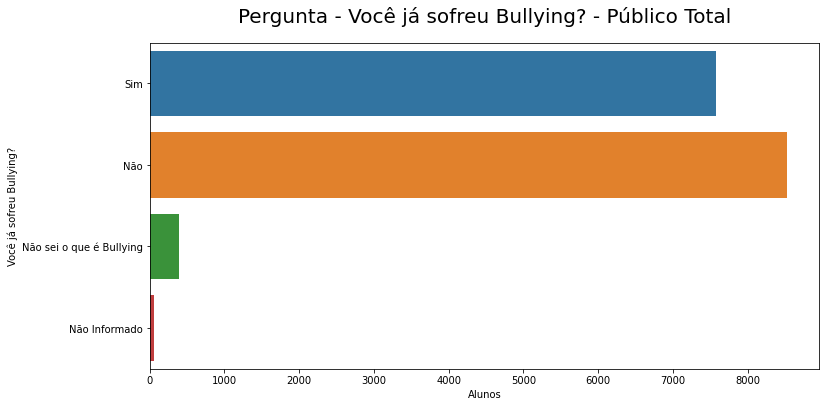

In [160]:
grafico_bullying(dados, "Total")

E vamos visualizar o mesmo gráfico para as idades

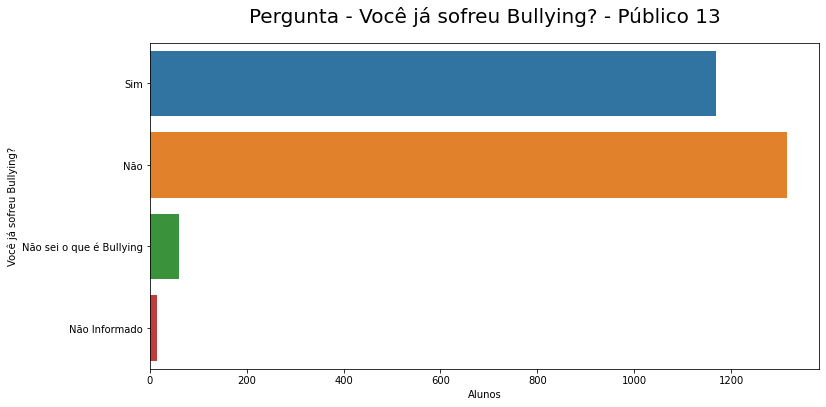

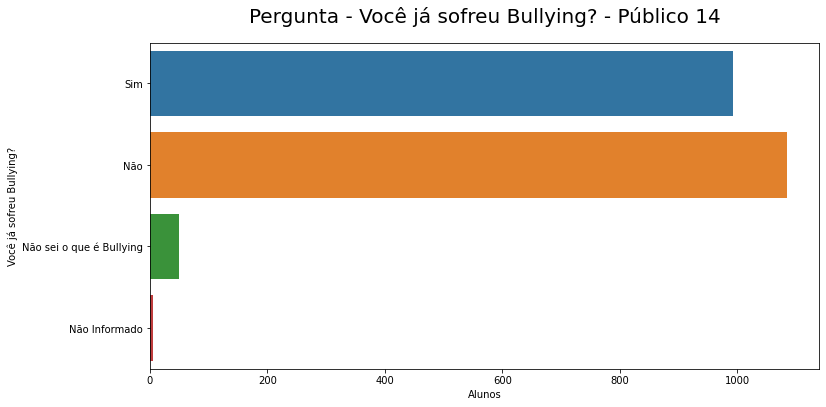

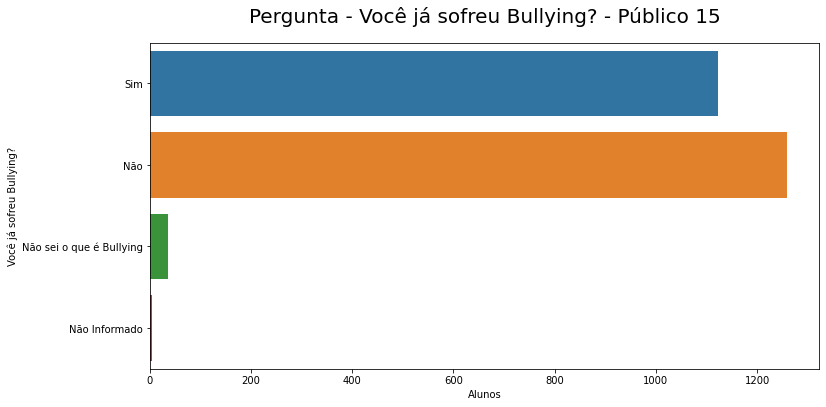

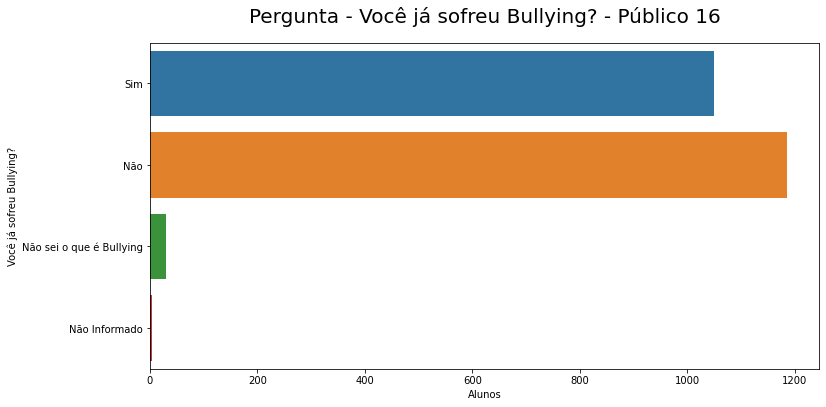

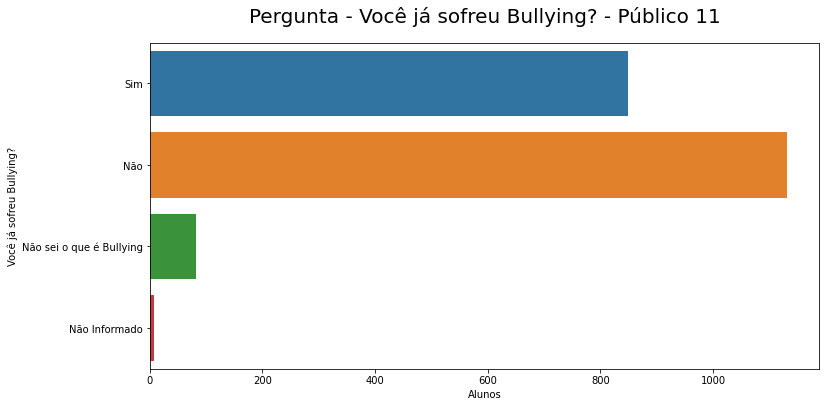

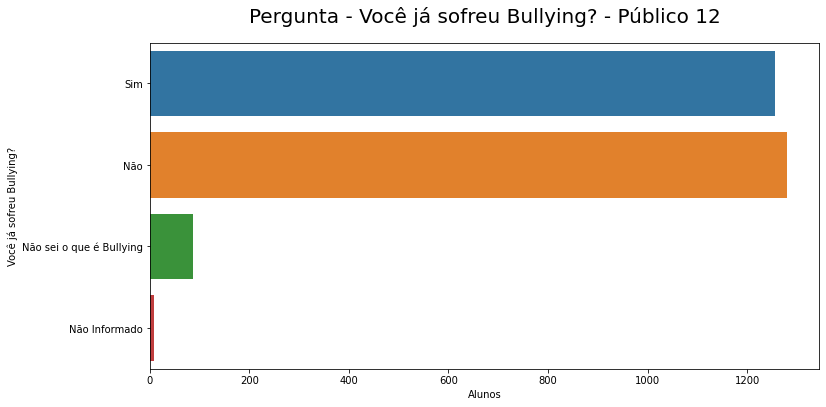

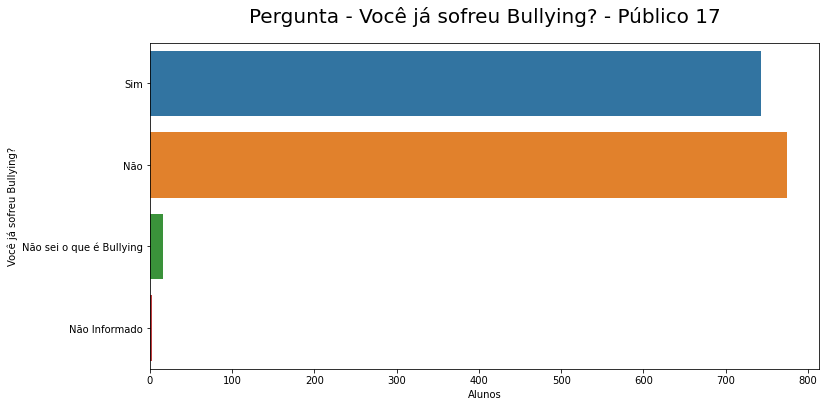

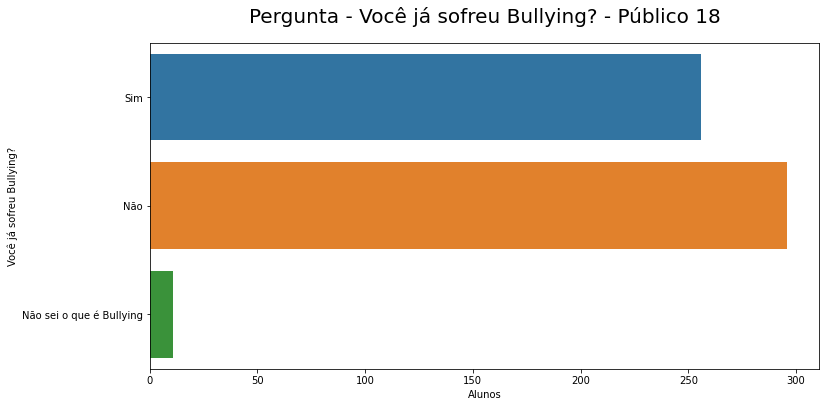

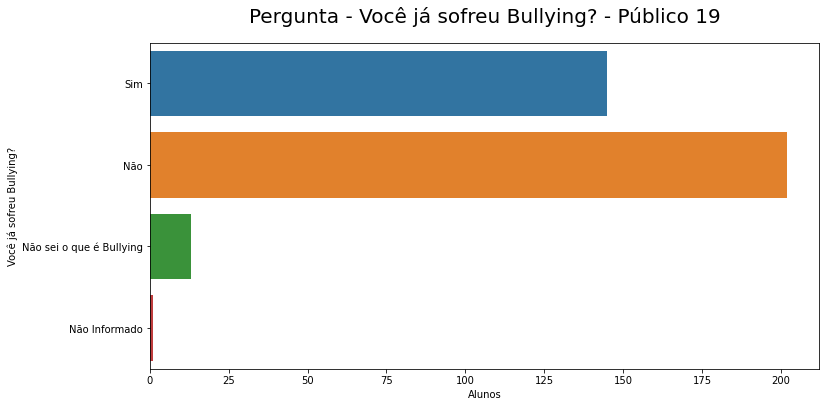

In [161]:
for age in dados.VB01003.unique():
  grafico_bullying(dados[dados['VB01003'] == age], str(age))


Vê-se que os respondentes com 11 anos ou menos ou 19 ou mais dizem sofrer menos bullying que os demais grupos

In [235]:
VB07007 = {1:'1-Nunca', 2:'2-Raramente', 3:'3-Às vezes', 4:'4-Frequente', 5: '5-Sempre', 99:'6-Não Informado'}
VB07010 = {1:'1-Sim', 2:'2-Não', 3: '3-Não sei', 99: '4-Não Informado'}
round(pd.crosstab(index=[dados['VB07007'].replace(VB07007)], columns=dados['VB07010'].replace(VB07010), normalize='columns')*100,2)

VB07010,1-Sim,2-Não,3-Não sei,4-Não Informado
VB07007,,,,
1-Nunca,40.03,69.41,48.06,3.85
2-Raramente,26.03,17.86,11.11,0.00
3-Às vezes,21.43,9.60,25.84,11.54
4-Frequente,6.75,1.55,6.72,0.00
5-Sempre,5.34,1.27,8.01,1.92
6-Não Informado,0.42,0.32,0.26,82.69


In [199]:
pd.crosstab(index=[dados['VB07007'].replace(VB07007)], columns=dados['VB07010'].replace(VB07010))

VB07010,1-Sim,2-Não,3-Não sei,4-Não Informado
VB07007,,,,
1-Nunca,3036,5923,186,2
2-Raramente,1974,1524,43,0
3-Às vezes,1625,819,100,6
4-Frequente,512,132,26,0
5-Sempre,405,108,31,1
6-Não Informado,32,27,1,43


In [201]:
chi2,p_value,_,_ = st.chi2_contingency(pd.crosstab(index=[dados['VB07007'].replace(VB07007)], columns=dados['VB07010'].replace(VB07010)))

In [202]:
teste_chi2(p_value)

Podemos rejeitar a hipótese nula de que as variáveis são independentes entre si
Ou seja, podemos aceitar a hipótese alternativa de que as variáveis são dependentes entre si


Esta tabela é interessante pois nos mostra que nem sempre o bullying sofrido está presente ou vem dos colegas e também que uma parcela dos respondentes dizerm não sofrer bullying, quando claramente estão sofrendo na resposta seguinte. Veja que 12,41% dos adolescentes que responderam não sofrer bullying sofreram com agressões morais por parte dos colegas mais de uma vez nos últimos 30 dias, e 17.86% sofreram pelo menos uma vez com ações consideradas bullying por seus colegas.

Vamos investigar agora os 40% dos respondentes que responderam já ter sofrido bullying que manifestaram não ter sofrido com isso por parte dos colegas nos últimos 30 dias. Há algumas perguntas no questionário que envolvem os familiares, ou o respondente pode não sofrer mais com isso.

É interessante ainda ver que entre os que responderam que não sabem o que é bullying, 40% sofreu com isso mais de uma vez nos últimos 30 dias, e que a proporção entre as respostas Raramente e às vezes, que segue uma curva descendente nas demais respostas, se inverte entre quem não sabe o que é bullying

O teste chi2 demonstra que estas variáveis não são independentes enter si, usando a significância de 0,05.

In [188]:
bullying_sim = dados[dados['VB07010'] == 1]
bullying_sim

,REGEOGR,VB01001,VB01002,VB01003,VB01004,VB01005,VB01006,VB01007,VB01008A,VB01010A,VB01011,VB01012,VB01013,VB01014,VB01015A,VB01016,VB01017,VB01018,VB01019,VB01020A,VB01021,VB01022,VB01023,VB01024,VB01025,VB01026,VB02001,VB02002,VB02004A,VB02010,VB02011,VB02013,VB02017A,VB02018A,VB02019A,VB02020A,VB02021,VB02022,VB02023,VB02024,...,VB11005,VB11006,VB11007,VB12001,VB12002,VB12003,VB13001,VB13002A,VB13004A,VB13005,VB13006,VB13007,VB13008,VB13009,VB14001,VB14002,VB16001A01,VB16001A02,VB16001A03,VB16001A04,VB16001A05,VB16001A06,VB16001A07,VB16001A08,VB17001,VB17002,VB17003,VB17004,VB17005,VB17006,ESTRATO_EXP,ESTRATOGEOREG,PESO,V0006,V0007,V0008,V0041,aluno,escola,turma
2,1,1,4,13,6,7,1,1,5,5,2,-1,2,1,1,1,1,2,3,1,4,1,2,2,5,3,2,3,1,8,2,8,1,1,5,5,1,8,5,1,...,2,1,2,1,2,3,1,2,1,2,5,99,1,-1,2,2,1,1,1,1,1,1,1,1,482.0,1614.0,48.2,161.4,2,2,1223,1,299.735235,1,2,4,1,3,1,296
3,1,1,1,14,6,7,1,1,7,4,2,-1,1,1,1,1,1,2,4,2,4,1,2,2,6,3,2,4,1,3,2,7,1,5,1,-1,2,5,3,1,...,2,1,2,2,2,4,1,10,3,1,2,-1,1,-1,2,2,1,2,2,2,1,2,2,2,694.0,1725.0,69.4,172.5,2,3,1223,1,355.170081,1,2,4,1,4,1,296
4,1,1,1,13,9,7,1,2,5,4,2,-1,2,1,1,1,1,2,5,1,4,1,2,2,6,5,6,3,5,2,6,2,1,5,1,5,1,3,2,3,...,2,1,4,2,2,4,1,3,2,2,2,13,1,-1,1,2,1,1,1,1,1,1,1,1,789.0,1675.0,78.9,167.5,2,4,1223,1,299.735235,1,2,4,1,5,1,296
5,1,2,4,14,12,6,1,1,7,3,2,-1,1,1,1,1,1,2,4,1,4,1,2,2,5,3,7,7,8,3,8,1,5,6,1,4,1,3,1,1,...,2,2,4,2,2,4,1,2,2,1,1,1,1,2,1,2,2,2,1,2,2,2,1,2,729.0,1605.0,72.9,160.5,2,4,1223,1,355.170081,1,2,4,1,6,1,296
6,1,2,1,14,3,7,1,1,7,3,2,-1,1,1,1,1,1,2,5,1,4,1,2,2,5,3,8,2,3,1,3,2,1,1,5,4,1,2,1,2,...,2,2,2,5,5,4,1,3,1,2,3,5,1,1,2,2,2,2,2,1,2,2,2,2,493.0,1575.0,49.3,157.5,2,2,1223,1,355.170081,1,2,4,1,7,1,296
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16542,5,1,2,14,2,7,1,2,5,3,2,-1,2,1,2,1,2,2,2,2,2,1,1,2,6,3,8,4,5,8,8,4,1,5,1,1,1,8,4,1,...,2,1,2,1,1,4,1,1,1,1,1,3,1,-1,1,1,1,1,2,1,1,1,2,2,612.0,1711.0,61.2,171.1,2,2,5121,5,319.915182,1,1,2,-1,16543,370,442
16545,5,2,1,13,9,7,1,2,5,3,1,2,1,1,1,1,1,1,4,2,2,1,2,2,1,1,2,8,1,8,1,4,5,5,1,1,1,2,1,1,...,2,1,4,4,2,2,2,-1,3,2,3,-1,1,1,1,2,1,2,2,2,2,2,2,2,825.0,1585.0,82.5,158.5,2,4,5121,5,289.864054,1,1,2,-1,16546,370,442
16547,5,2,4,12,11,8,1,1,7,4,2,-1,2,1,1,2,2,2,2,2,2,1,1,2,5,2,7,1,2,3,4,2,6,3,3,2,1,1,1,1,...,2,1,1,3,2,4,2,-1,3,2,1,-1,2,2,1,1,1,2,2,2,2,2,2,2,515.0,1565.0,51.5,156.5,2,2,5121,5,323.598680,1,1,2,-1,16548,370,442
16548,5,1,4,13,6,7,1,2,8,4,2,-1,2,2,2,1,2,2,2,2,2,1,2,2,5,3,6,1,1,2,7,4,1,1,6,1,1,1,1,1,...,2,1,2,5,3,4,2,-1,3,1,2,-1,1,-1,1,1,1,2,2,2,2,2,2,2,532.0,1605.0,53.2,160.5,2,2,5121,5,289.864054,1,1,2,-1,16549,370,442


In [192]:
#criando um subset só entre as pessoas que dizem ter sofrido bullying mas que não sofreram bullying por parte dos colegas nos últimos 30 dias
bullying_sim_nunca = bullying_sim[bullying_sim['VB07007'] == 1]
bullying_sim_nunca

,REGEOGR,VB01001,VB01002,VB01003,VB01004,VB01005,VB01006,VB01007,VB01008A,VB01010A,VB01011,VB01012,VB01013,VB01014,VB01015A,VB01016,VB01017,VB01018,VB01019,VB01020A,VB01021,VB01022,VB01023,VB01024,VB01025,VB01026,VB02001,VB02002,VB02004A,VB02010,VB02011,VB02013,VB02017A,VB02018A,VB02019A,VB02020A,VB02021,VB02022,VB02023,VB02024,...,VB11005,VB11006,VB11007,VB12001,VB12002,VB12003,VB13001,VB13002A,VB13004A,VB13005,VB13006,VB13007,VB13008,VB13009,VB14001,VB14002,VB16001A01,VB16001A02,VB16001A03,VB16001A04,VB16001A05,VB16001A06,VB16001A07,VB16001A08,VB17001,VB17002,VB17003,VB17004,VB17005,VB17006,ESTRATO_EXP,ESTRATOGEOREG,PESO,V0006,V0007,V0008,V0041,aluno,escola,turma
3,1,1,1,14,6,7,1,1,7,4,2,-1,1,1,1,1,1,2,4,2,4,1,2,2,6,3,2,4,1,3,2,7,1,5,1,-1,2,5,3,1,...,2,1,2,2,2,4,1,10,3,1,2,-1,1,-1,2,2,1,2,2,2,1,2,2,2,694.0,1725.0,69.4,172.5,2,3,1223,1,355.170081,1,2,4,1,4,1,296
6,1,2,1,14,3,7,1,1,7,3,2,-1,1,1,1,1,1,2,5,1,4,1,2,2,5,3,8,2,3,1,3,2,1,1,5,4,1,2,1,2,...,2,2,2,5,5,4,1,3,1,2,3,5,1,1,2,2,2,2,2,1,2,2,2,2,493.0,1575.0,49.3,157.5,2,2,1223,1,355.170081,1,2,4,1,7,1,296
8,1,1,4,13,8,7,1,1,7,5,2,-1,2,1,1,1,1,2,3,2,4,1,2,2,5,3,2,1,5,3,6,2,1,4,1,-1,2,2,1,1,...,2,2,4,1,1,4,1,1,1,3,2,7,1,-1,2,2,1,2,2,2,2,2,2,2,783.0,1700.0,78.3,170.0,2,4,1223,1,299.735235,1,2,4,1,9,1,296
13,1,2,4,14,10,6,2,1,7,4,2,-1,1,1,1,1,1,2,4,1,4,1,1,2,5,3,6,2,3,2,1,3,5,1,1,-1,2,4,3,3,...,2,1,1,3,3,4,1,7,1,2,1,5,1,1,1,2,2,2,2,2,1,2,2,2,463.0,1553.0,46.3,155.3,2,2,1223,1,355.170081,1,2,4,1,14,1,296
19,1,2,3,14,5,7,1,2,8,5,2,-1,1,1,1,1,1,2,4,2,4,1,2,2,5,3,8,5,2,2,4,5,5,6,1,5,1,3,3,1,...,2,2,2,3,1,4,1,3,2,1,2,5,1,1,2,2,2,2,2,2,2,2,1,2,603.0,1619.0,60.3,161.9,2,2,1223,1,355.170081,1,2,4,1,20,1,296
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16522,5,1,2,14,1,7,1,1,2,5,2,-1,1,1,2,1,1,2,3,2,2,1,2,2,1,4,8,3,1,8,5,3,1,1,1,1,1,8,6,2,...,2,1,1,1,1,1,2,-1,1,5,1,2,1,-1,2,2,2,2,2,2,2,2,1,2,456.0,1678.0,45.6,167.8,2,2,5121,5,319.915182,1,1,2,-1,16523,370,442
16524,5,2,2,13,6,7,1,2,5,4,2,-1,1,2,1,1,1,2,4,2,2,1,2,2,5,3,8,2,6,2,2,1,1,5,5,1,1,1,1,1,...,2,1,1,5,1,2,2,-1,2,1,1,99,1,1,1,1,2,2,2,2,1,2,2,2,585.0,1569.0,58.5,156.9,2,3,5121,5,289.864054,1,1,2,-1,16525,370,442
16530,5,2,2,14,1,7,1,1,8,5,2,-1,2,1,1,1,2,2,2,1,2,1,1,2,6,4,8,2,1,8,7,8,5,1,5,1,1,2,1,1,...,2,1,4,3,1,4,1,1,1,1,1,13,1,1,2,1,1,2,2,2,2,2,2,2,530.0,1646.0,53.0,164.6,2,2,5121,5,319.915182,1,1,2,-1,16531,370,442
16536,5,2,3,14,9,6,1,2,2,4,1,1,2,1,2,2,2,1,2,2,2,1,2,2,5,3,8,2,6,5,8,4,1,6,1,4,1,4,1,1,...,2,2,2,1,2,4,1,1,2,3,2,5,1,1,1,2,2,2,2,1,2,2,2,2,731.0,1555.0,73.1,155.5,2,4,5121,5,319.915182,1,1,2,-1,16537,370,442


In [234]:
#vamos fazer a mesma análise mas com a pergunta indireta e mais próxima (nos últimos 30 dias)
round(pd.crosstab(dados['VB01003'], dados['VB07007'], normalize='index')*100,2)

VB07007,1,2,3,4,5,99
VB01003,,,,,,
11,53.96,17.18,17.47,5.21,5.02,1.16
12,49.96,19.51,19.48,5.88,4.67,0.49
13,53.61,20.19,16.56,4.53,4.02,1.09
14,53.02,21.57,17.77,4.13,2.77,0.75
15,56.95,24.16,13.03,3.05,2.43,0.37
16,59.74,23.79,10.88,3.08,2.25,0.26
17,56.93,25.83,12.30,2.67,1.95,0.33
18,61.46,20.43,14.03,2.31,1.60,0.18
19,69.53,15.51,11.36,1.39,1.94,0.28


### **Quando o Bullying envolve a imagem corporal do estudante**

15% dos estudantes que responderam ter sofrido bullying nos últimos 30 dias, disseram que o motivo foi a aparência de seu corpo

In [225]:
#separando o público que respondeu a pergunta vb07008 diferente de questão pulada
subset = dados[dados['VB07008']!= -1]

In [226]:
subset['VB07008'].value_counts(normalize=True)*100

7     61.442650
4     15.192992
3      9.649603
1      5.516014
2      3.298659
5      2.189981
6      1.628798
99     1.081303
Name: VB07008, dtype: float64

In [233]:
sexo= {1: 'M', 2: 'F'}
motivo = {1:'Raça', 2:'Religião', 3:'Rosto', 4:'Corpo', 5:'Orientação Sexual', 6:'Origem', 7:'Outros', 99: 'Não Informado'}

round(pd.crosstab(columns=subset['VB01001'].replace(sexo), index=subset['VB07008'].replace(motivo), normalize='columns')*100,2)

VB01001,F,M
VB07008,,
Corpo,17.32,13.17
Não Informado,0.98,1.18
Orientação Sexual,1.26,3.07
Origem,1.43,1.82
Outros,63.31,59.67
Raça,3.90,7.05
Religião,2.92,3.66
Rosto,8.87,10.39


In [240]:
dados['VB01001'].value_counts(normalize=True)

1    0.500544
2    0.499456
Name: VB01001, dtype: float64

In [241]:
subset['VB01001'].value_counts(normalize=True)

1    0.512456
2    0.487544
Name: VB01001, dtype: float64

Vemos que para ambos os gêneros, a aparência do corpo é um dos principais motivo de bullying identificados na pesquisa, sendo mais prevalente no gênero feminino que no masculino (17% contra 13%). Os meninos sofrem mais com ataques à aparência do rosto (10% contra 8%) e à sua raça (7% contra 3%). Em ambos os gêneros no entanto, a pesquisa não conseguiu determinar o motivo da maior parte das práticas de bullying, que ficaram no grupo de Outros. 

Vamos explorar agora especificamente o grupo de pessoas que sofre com bullying por causa do corpo e verificar se há alguma relação com sua aparência de fato. dos 16mil respondentes, 1110 disseram ter experimentado bullying por causa da aparência de seu corpo.

In [221]:
#subset de pessoas que sofreram bullying por parte dos colegas nos últimos 30 dias que dizem ter sofrido pela aparência de seu corpo
bullying_corpo = dados[dados['VB07008'] == 4]
bullying_corpo

,REGEOGR,VB01001,VB01002,VB01003,VB01004,VB01005,VB01006,VB01007,VB01008A,VB01010A,VB01011,VB01012,VB01013,VB01014,VB01015A,VB01016,VB01017,VB01018,VB01019,VB01020A,VB01021,VB01022,VB01023,VB01024,VB01025,VB01026,VB02001,VB02002,VB02004A,VB02010,VB02011,VB02013,VB02017A,VB02018A,VB02019A,VB02020A,VB02021,VB02022,VB02023,VB02024,...,VB11005,VB11006,VB11007,VB12001,VB12002,VB12003,VB13001,VB13002A,VB13004A,VB13005,VB13006,VB13007,VB13008,VB13009,VB14001,VB14002,VB16001A01,VB16001A02,VB16001A03,VB16001A04,VB16001A05,VB16001A06,VB16001A07,VB16001A08,VB17001,VB17002,VB17003,VB17004,VB17005,VB17006,ESTRATO_EXP,ESTRATOGEOREG,PESO,V0006,V0007,V0008,V0041,aluno,escola,turma
4,1,1,1,13,9,7,1,2,5,4,2,-1,2,1,1,1,1,2,5,1,4,1,2,2,6,5,6,3,5,2,6,2,1,5,1,5,1,3,2,3,...,2,1,4,2,2,4,1,3,2,2,2,13,1,-1,1,2,1,1,1,1,1,1,1,1,789.0,1675.0,78.9,167.5,2,4,1223,1,299.735235,1,2,4,1,5,1,296
5,1,2,4,14,12,6,1,1,7,3,2,-1,1,1,1,1,1,2,4,1,4,1,2,2,5,3,7,7,8,3,8,1,5,6,1,4,1,3,1,1,...,2,2,4,2,2,4,1,2,2,1,1,1,1,2,1,2,2,2,1,2,2,2,1,2,729.0,1605.0,72.9,160.5,2,4,1223,1,355.170081,1,2,4,1,6,1,296
15,1,2,4,14,9,6,1,1,7,5,2,-1,1,1,1,1,1,2,5,1,4,1,1,2,5,1,1,2,6,3,4,4,1,2,3,-1,2,2,1,1,...,2,2,4,2,1,4,1,2,1,2,2,1,1,1,2,2,2,2,2,2,2,2,1,2,944.0,1654.0,94.4,165.4,2,4,1223,1,355.170081,1,2,4,1,16,1,296
21,1,2,5,14,3,7,1,1,8,3,2,-1,2,1,1,1,1,2,4,1,4,1,2,2,5,3,1,8,1,8,8,2,1,3,1,1,1,8,4,1,...,1,2,5,1,3,4,1,1,3,1,1,-1,1,1,2,1,2,2,1,2,2,2,2,2,392.0,1516.0,39.2,151.6,2,2,1223,1,355.170081,1,2,4,1,22,1,296
28,1,2,4,14,2,7,1,2,7,4,2,-1,1,1,1,1,1,1,4,1,4,1,2,2,5,3,8,3,1,3,4,2,1,6,1,-1,2,3,3,1,...,2,1,2,1,2,4,1,3,1,2,2,5,1,1,2,2,2,2,2,2,1,2,2,2,429.0,1580.0,42.9,158.0,2,2,1223,1,355.170081,1,2,4,1,29,1,296
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16511,5,2,3,12,5,9,1,1,4,6,2,-1,2,1,2,1,1,1,2,1,1,3,1,1,4,2,2,4,8,6,8,5,1,6,1,1,1,2,2,1,...,2,1,2,3,3,4,2,-1,2,1,4,6,1,1,2,2,2,2,2,1,2,2,2,2,313.0,1523.0,31.3,152.3,2,1,5121,5,346.712871,1,1,2,-1,16512,370,441
16520,5,1,4,14,9,6,2,1,6,2,2,-1,2,1,2,2,2,2,2,2,2,1,2,2,1,3,7,4,8,8,8,7,1,5,1,4,1,8,2,1,...,1,2,2,3,2,1,2,-1,1,4,1,13,1,-1,2,2,2,2,2,2,1,2,2,2,507.0,1692.0,50.7,169.2,2,2,5121,5,319.915182,1,1,2,-1,16521,370,442
16525,5,1,1,12,4,9,1,2,2,4,2,-1,2,2,1,1,1,2,5,2,2,1,2,2,3,3,1,1,1,1,7,2,1,2,1,1,1,3,1,2,...,2,2,5,3,1,3,1,7,2,3,5,13,1,-1,1,1,2,1,2,2,2,1,2,1,558.0,1512.0,55.8,151.2,2,4,5121,5,323.598680,1,1,2,-1,16526,370,442
16533,5,2,4,13,7,7,1,1,5,3,2,-1,2,1,1,1,1,1,2,2,2,1,2,2,5,3,7,7,7,8,5,8,1,1,6,4,1,6,7,1,...,2,2,5,5,1,1,2,-1,2,4,3,13,1,1,1,2,2,2,2,2,1,2,2,2,851.0,1618.0,85.1,161.8,2,4,5121,5,289.864054,1,1,2,-1,16534,370,442


Deste universo, 29,63% dos estudantes se declaram insatisfeitos com seu corpo, e 14,41% se declaram muito insatisfeitos com seu corpo, mas 38,10% se declaram satisfeitos ou muito satisfeitos com seu corpo. No entanto, esses valores são bem diferentes da amostra total. Enquanto 44,04% do grupo dos que sofrem bullying por causa de seu corpo não estão satisfeitos com ele, apenas 18,35% do total de alunos que responderam à pesquisa tem essa percepção quanto ao próprio corpo. 

Como era de se esperar, podemos perceber que a pressão da sociedade, neste caso na forma de zoação por parte dos colegas de escola, tem uma clara influência sobre a auto-imagem do adolescente.

In [242]:
#Visualizando a questão tratada
get_question_description('VB11007')

{'Descrição': {'1': 'Muito satisfeito(a)',
  '2': 'Satisfeito(a)',
  '3': 'Indiferente',
  '4': 'Insatisfeito(a)',
  '5': 'Muito insatisfeito(a)',
  99: 'Não informado'},
 'Pergunta': 'Como você se sente em relação ao seu corpo?'}

In [63]:
#vamos ver quantas pessoas que sofrem com bullying por causa do corpo, se consideram insatisfeitas com ele
bullying_corpo['VB11007'].value_counts(normalize=True)*100

4     29.639640
2     25.495495
3     17.477477
5     14.414414
1     12.612613
99     0.360360
Name: VB11007, dtype: float64

In [64]:
dados['VB11007'].value_counts(normalize=True)*100

2     41.797536
1     27.832810
4     14.049287
3     10.914472
5      4.312636
99     1.093259
Name: VB11007, dtype: float64

Vamos ver agora como a condição corporal destes alunos se compara ao da amostra geral. Para isso vamos usar a variável VB17006 (Variável identificadora do estado nutricional do estudante)

In [243]:
get_question_description('VB17006')

{'Descrição': {1: 'Deficit de peso',
  2: 'Eutrofia',
  3: 'Sobrepeso',
  4: 'Obesidade'},
 'Pergunta': 'Variável identificadora do estado nutricional do estudante, onde: déficit de peso=1'}

In [65]:
#vamos ver se isso realmente reflete na condição corporal dos estudantes, usando a pergunta VB17006 (Variável identificadora do estado nutricional do estudante)
bullying_corpo['VB17006'].value_counts(normalize=True)*100

2    42.072072
4    32.252252
3    20.000000
1     5.675676
Name: VB17006, dtype: float64

In [244]:
dados['VB17006'].value_counts(normalize=True)*100

2    69.334380
3    18.289442
4     9.144721
1     3.231457
Name: VB17006, dtype: float64

Vemos que há uma prevalência maior de pessoas com sobrepeso e obesidade entre aqueles que sofrem com o bullying por causa do corpo (52% entre os que sofrem com o bullying contra 27,42% do público da amostra). 

No entanto, é interessante, e preocupante, perceber que ainda assim 42% das pessoas que sofrem com bullying por causa da aparência de seu corpo, são consideradas saudáveis neste quesito, o que pode nos levar a crer que alguns destes alunos podem sofrer de [dismorfia](https://www.cellerafarma.com.br/bem-estar/disturbio-de-imagem-entenda-o-que-e), ou transtorno dismórfico corporal (TDC), que se caracteriza pela percepção alterada de si mesmo diante do espelho: quando o que a pessoa enxerga no espelho não condiz com a realidade. É um caminho interessante para uma pesquisa futura

In [66]:
#vamos ver agora a proporção de gênero nesta amostra
bullying_corpo['VB01001'].value_counts(normalize=True)*100

2    55.585586
1    44.414414
Name: VB01001, dtype: float64

Vemos ainda, conforme tabela abaixo, que o caso se agrava quando dividimos o nosso público por gênero. Vê-se que 46,52% das meninas que sofrem com bullying por causa de seu corpo tem um peso saudável para sua idade e altura. 

Em números absolutos, o grupo que mais sofre com bullying por causa de seu corpo são meninas saudáveis, que perfazem 25% ou 1/4 das pessoas que sofrem com bullying por causa da aparência de seu corpo.

In [246]:
#minha hipótese é de que as pessoas de peso normal que sofrem bullying estão concentradas no gênero feminino
round(pd.crosstab(columns=bullying_corpo['VB01001'].replace(sexo), 
            index=bullying_corpo['VB17006'].replace(get_question_description('VB17006')['Descrição']), normalize='columns')*100,2)

VB01001,F,M
VB17006,,
Deficit de peso,6.32,4.87
Eutrofia,46.52,36.51
Obesidade,25.77,40.37
Sobrepeso,21.39,18.26


In [253]:
round(pd.crosstab(columns=bullying_corpo['VB01001'].replace(sexo),
            index=bullying_corpo['VB17006'].replace(get_question_description('VB17006')['Descrição']), normalize=True)*100,2)

VB01001,F,M
VB17006,,
Deficit de peso,3.51,2.16
Eutrofia,25.86,16.22
Obesidade,14.32,17.93
Sobrepeso,11.89,8.11


Já tivemos uma resposta visual de que o gênero impacta a variável de saúde nutricional no público de alunos que sofrem bullying por causa de seu corpo, mas vamos fazer o teste do chi quadrado para confirmar que estas variáveis são dependentes:

In [250]:
chi2,p_value,_,_ = st.chi2_contingency(pd.crosstab(columns=bullying_corpo['VB01001'], index=bullying_corpo['VB17006']))

In [251]:
teste_chi2(p_value)

Podemos rejeitar a hipótese nula de que as variáveis são independentes entre si
Ou seja, podemos aceitar a hipótese alternativa de que as variáveis são dependentes entre si


Quando fazemos a proporção por gênero e condição nutricional, vemos que realmente, 61% das pessoas que sofrem bullying por causa de seu corpo são do gênero feminino. Podemos ver que a imagem corporal é um ponto mais sensível para as meninas, o que pode ser reflexo de pressões sociais, representadas pelas inúmeras publicações de beleza voltadas para o público feminino. Como se trata de uma pesquisa de 2015, será interessante verificar a próxima edição deste estudo e a influência das redes sociais nestes índices.  

In [255]:
vb17006 = get_question_description('VB17006')['Descrição']
pd.crosstab(columns=bullying_corpo['VB01001'].replace(sexo), 
            index=bullying_corpo['VB17006'].replace(vb17006), normalize='index')*100

VB01001,F,M
VB17006,,
Deficit de peso,61.904762,38.095238
Eutrofia,61.456103,38.543897
Obesidade,44.413408,55.586592
Sobrepeso,59.459459,40.540541


In [266]:
pd.crosstab(columns=bullying_corpo['VB01003'], 
                          index=[bullying_corpo['VB17006'].replace(vb17006)])

VB01003,11,12,13,14,15,16,17,18,19
VB17006,,,,,,,,,
Deficit de peso,2,12,15,14,6,7,4,2,1
Eutrofia,46,86,76,66,64,60,57,6,6
Obesidade,53,75,65,48,46,38,22,6,5
Sobrepeso,29,38,41,32,31,31,12,6,2


Como há poucos dados de pessoas com 18 e 19 anos, vamos considerá-los como outliers e não vamos analisar a influência nestes grupos. 

Vê-se pela planilha abaixo que conforme aumenta a idade das pessoas que sofrem com bullying por causa do corpo, aumenta a proporção de alunos com peso normal para a idade e altura. 

In [267]:
#vamos ver se há alguma concentração de idade neste tipo de bullying
cross = round(pd.crosstab(columns=bullying_corpo['VB01003'], index=bullying_corpo['VB17006'].replace(vb17006), normalize='columns')*100,2)
cross.style.apply(highlight_max)

VB01003,11,12,13,14,15,16,17,18,19
VB17006,,,,,,,,,
Deficit de peso,1.540000,5.690000,7.610000,8.750000,4.080000,5.150000,4.210000,10.000000,7.140000
Eutrofia,35.380000,40.760000,38.580000,41.250000,43.540000,44.120000,60.000000,30.000000,42.860000
Obesidade,40.770000,35.550000,32.990000,30.000000,31.290000,27.940000,23.160000,30.000000,35.710000
Sobrepeso,22.310000,18.010000,20.810000,20.000000,21.090000,22.790000,12.630000,30.000000,14.290000


Vamos ver se realmente há alguma indicação de dismorfia no público que sofre com bullying por causa da aparência de seu corpo, usando a questão VB11001 (Quanto ao seu corpo, você se considera: )

In [272]:
get_question_description('VB11001')

{'Descrição': {'1': 'Muito magro(a) ',
  '2': 'Magro(a)',
  '3': 'Normal',
  '4': 'Gordo(a)',
  '5': 'Muito Gordo(a)',
  99: 'Não informado'},
 'Pergunta': 'Quanto ao seu corpo, você se considera: '}

Podemos ver na comparação abaixo que há uma clara diferença na auto-imagem daqueles que sofrem bullying por causa do seu corpo com relação à amostra do estudo, sendo destaque o fato de que apenas 31% deste público com condição nutricional normal se consideram normais, contra 54% do público da amostra na mesma condição. 

Entre os que sofrem esse tipo de bullying, em torno de 20% se consideram gordos ou muito gordos e 48% magros ou muito magros, enquanto na amostra total, esses números são 9% e 31% respectivamente.

In [281]:
vb11001 = {1: 'Muito magro(a) ',  2: 'Magro(a)',  3: 'Normal',  4: 'Gordo(a)',  5: 'Muito Gordo(a)',  99: 'Não informado'}
round(pd.crosstab(index = bullying_corpo['VB17006'].replace(vb17006), 
            columns = [bullying_corpo['VB11001'].replace(vb11001)], normalize='index')*100,2)

VB11001,Gordo(a),Magro(a),Muito Gordo(a),Muito magro(a),Normal,Não informado
VB17006,,,,,,
Deficit de peso,1.59,31.75,4.76,49.21,12.70,0.00
Eutrofia,16.70,30.19,3.43,18.63,31.05,0.00
Obesidade,67.88,1.12,22.35,0.00,8.38,0.28
Sobrepeso,57.21,3.60,13.06,0.90,25.23,0.00


In [282]:
round(pd.crosstab(index = dados['VB17006'].replace(vb17006), 
            columns = [dados['VB11001'].replace(vb11001)], normalize='index')*100,2)

VB11001,Gordo(a),Magro(a),Muito Gordo(a),Muito magro(a),Normal,Não informado
VB17006,,,,,,
Deficit de peso,1.50,46.92,2.06,27.48,20.37,1.68
Eutrofia,8.11,25.11,0.83,6.59,58.40,0.97
Obesidade,62.09,1.72,11.36,0.73,23.18,0.92
Sobrepeso,35.40,3.37,4.39,1.25,54.76,0.83


Como a visualização por gênero ficou muito confusa no mesmo crosstab, vamos ver como a auto-imagem se compara com a condição nutricional entre meninos e meninas

In [284]:
#criando os subsets
bullying_corpo_f = bullying_corpo[bullying_corpo['VB01001'] == 2]
bullying_corpo_m = bullying_corpo[bullying_corpo['VB01001'] == 1]

In [285]:
round(pd.crosstab(index = bullying_corpo_f['VB17006'].replace(vb17006), 
            columns = [bullying_corpo_f['VB11001'].replace(vb11001)], normalize='index')*100,2)

VB11001,Gordo(a),Magro(a),Muito Gordo(a),Muito magro(a),Normal,Não informado
VB17006,,,,,,
Deficit de peso,0.00,30.77,2.56,53.85,12.82,0.00
Eutrofia,17.42,26.48,3.83,24.74,27.53,0.00
Obesidade,62.89,0.63,32.08,0.00,3.77,0.63
Sobrepeso,61.36,3.03,14.39,1.52,19.70,0.00


In [286]:
round(pd.crosstab(index = bullying_corpo_m['VB17006'].replace(vb17006), 
            columns = [bullying_corpo_m['VB11001'].replace(vb11001)], normalize='index')*100,2)

VB11001,Gordo(a),Magro(a),Muito Gordo(a),Muito magro(a),Normal
VB17006,,,,,
Deficit de peso,4.17,33.33,8.33,41.67,12.50
Eutrofia,15.56,36.11,2.78,8.89,36.67
Obesidade,71.86,1.51,14.57,0.00,12.06
Sobrepeso,51.11,4.44,11.11,0.00,33.33


Vemos que a distorção é mais presente entre as meninas  que sofrem com o bullying (apenas 27% das meninas que estão saudáveis se consideram normais, contra 36% dos garotos).

### **Dismorfia e transtornos alimentares**

 O transtorno dismórfico corporal geralmente não vem sozinho: cerca de 32% das pessoas que sofrem com o distúrbio de imagem sofrem de anorexia ou bulimia. [Fonte](https://www.cellerafarma.com.br/bem-estar/disturbio-de-imagem-entenda-o-que-e)

 Vamos ver se há algum impacto do bullying por causa da aparência no uso de medicamentos para perda de peso. Para isso vamos continuar usando nossos dados daqueles que sofreram bullying por causa de seu corpo, e as perguntas da Seção VB11: 

**VB11003** - NOS ÚLTIMOS 30 DIAS, você vomitou ou tomou laxantes para perder peso ou evitar ganhar peso? 

**VB11004A** - NOS ÚLTIMOS 30 DIAS, você tomou algum remédio, fórmula ou outro produto para perder peso, sem acompanhamento médico?



In [289]:
get_question_description('VB11003')['Descrição']


{'1': 'Sim', '2': 'Não', 99: 'Não informado'}

In [292]:
#Como as três perguntas possuem as mesmas respostas, vou criar um único dicionário para o replace
vb11 = {1: 'Sim', 2: 'Não', 99: 'Não informado'}

Vamos usar como parâmetro a condição nutricional daqueles que sofrem com bullying e compará-las com as 3 questões, e após faremos a mesma comparação para o público total da amostra

Estas são perguntas delicadas, e devemos levar em conta que há a possibilidade dos alunos não terem respondido com sinceridade. 

No entanto, vemos que o percentual de pessoas que tomaram laxantes ou vomitaram na tentativa de emagrecer é maior no público que sofre com bullying, e que das 128 pessoas que usaram este artifício nada saudável nos últimos 30 dias, 40 estão com peso normal, ou seja, 31%. 

A maior parte destas 128 pessoas é do gênero feminino (75 meninas contra 53 meninos, mas o percentual não é tão díspare quanto esperávamos considerando a divisão de gêneros no grupo. É importante ver que distúrbios alimentares não são uma prerrogativa do gênero feminino, e que há garotos descontentes o suficiente com seu corpo a ponto de buscar formas não saudáveis para emagrecer

In [299]:
pd.crosstab(index = bullying_corpo['VB17006'].replace(vb17006), 
            columns = [bullying_corpo['VB11003'].replace(vb11), bullying_corpo['VB01001'].replace(sexo)])

VB11003          Não      Não informado    Sim    
VB01001            F    M             F  M   F   M
VB17006                                           
Deficit de peso   38   22             0  0   1   2
Eutrofia         261  165             1  0  25  15
Obesidade        127  174             1  1  31  24
Sobrepeso        114   78             0  0  18  12

In [311]:
#público que sofreu bullying
bullying_corpo['VB11003'].replace(vb11).value_counts()

Não              979
Sim              128
Não informado      3
Name: VB11003, dtype: int64

In [312]:
#amostra total
dados['VB11003'].replace(vb11).value_counts()

Não              15107
Sim               1262
Não informado      187
Name: VB11003, dtype: int64

Vamos verificar agora o uso de medicamentos

In [301]:
pd.crosstab(index = bullying_corpo['VB17006'].replace(vb17006), 
            columns = [bullying_corpo['VB11004A'].replace(vb11),bullying_corpo['VB01001'].replace(sexo)])

VB11004A         Não      Não informado    Sim    
VB01001            F    M             F  M   F   M
VB17006                                           
Deficit de peso   38   22             0  0   1   2
Eutrofia         271  153             1  2  15  25
Obesidade        134  178             1  3  24  18
Sobrepeso        123   79             0  0   9  11

In [321]:
bullying_corpo['VB11004A'].replace(vb11).value_counts(normalize=True)*100

Não              89.909910
Sim               9.459459
Não informado     0.630631
Name: VB11004A, dtype: float64

In [322]:
dados['VB11004A'].replace(vb11).value_counts(normalize=True)*100

Não              92.069340
Sim               6.692438
Não informado     1.238222
Name: VB11004A, dtype: float64

In [318]:
pd.crosstab(index = bullying_corpo['VB11003'].replace(vb11), 
            columns = [bullying_corpo['VB11004A'].replace(vb11)])

VB11004A,Não,Não informado,Sim
VB11003,,,
Não,926,5,48
Não informado,1,2,0
Sim,71,0,57


57 dos entrevistados usaram os dois métodos não saudável de emagrecimento (vômito/laxantes + medicamentos sem acompanhamento médico). Vemos que há uma inversão no grupo de peso normal, sendo que os garotos dão preferência a medicamentos e fórmulas diferente da questão anterior. 

Como aconteceu no grupo anterior, a proporção é maior entre aqueles que sofrem bullying sobre a aparência do seu corpo, mas a divisão entre gêneros é mais sutil que o esperado

## **CONCLUSÃO**

Com este estudo pudemos verificar o impacto que o bullying tem na vida dos adolescentes, e com sua auto-imagem. Como sofrer ataques quanto a aparência de seu corpo pode levar jovens saudáveis a tomar medidas para emagrecer sem precisar, ou se sentirem insatisfeitos com sua própria imagem.

O público da amostra é restrito, apenas 1110 pessoas entre os mais de 16mil entrevistados, mas foi possível vislumbrar os danos desta atitude, bem como perceber um claro viés de gênero quanto às pressões sociais de beleza. 

Mas é interessante mostrar que a preocupação estética não se resume ao gênero feminino, e que há sim garotos sofrendo com possíveis distúrbios alimentares por causa do bullying. A pesquisa é de 2015 e aguardamos o lançamento da próxima edição para verificarmos a alteração e a possível influência das redes sociais na nova geração entrevistada.